<a href="https://colab.research.google.com/github/GurramVishalReddy/Liver-Cirrhosis-prediction/blob/main/Liver_cirrhosis_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

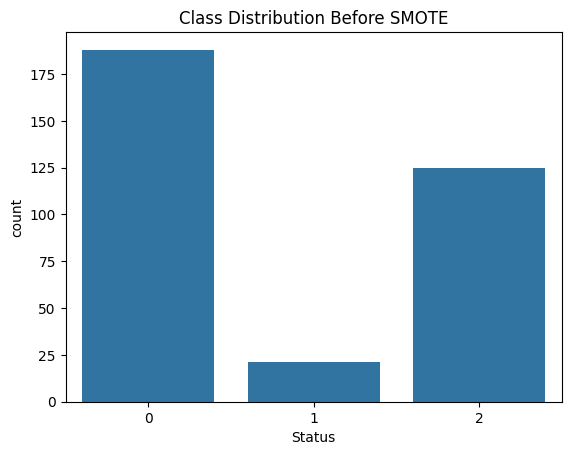

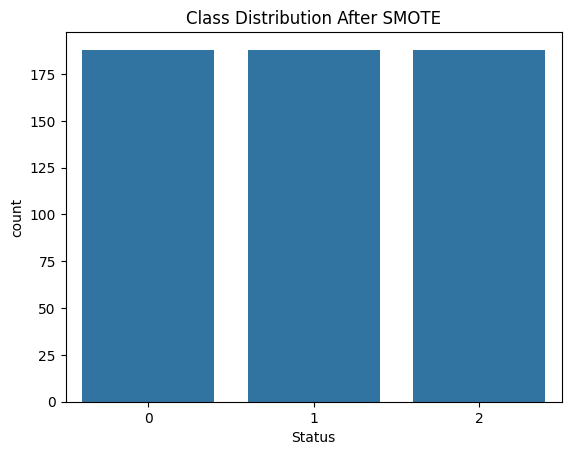

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

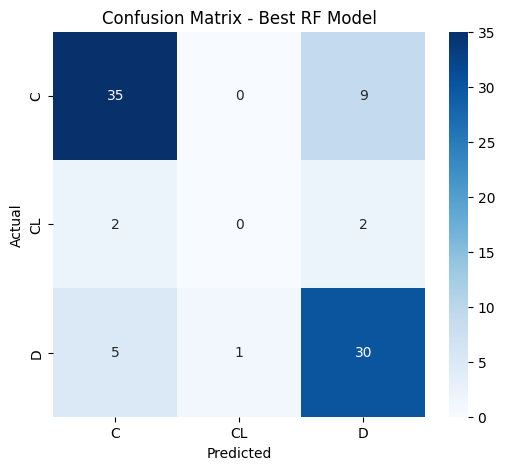

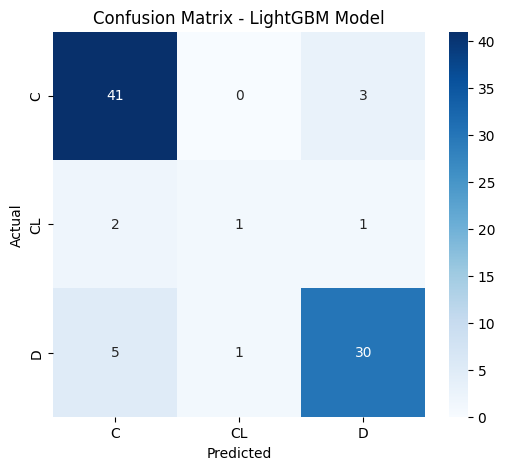

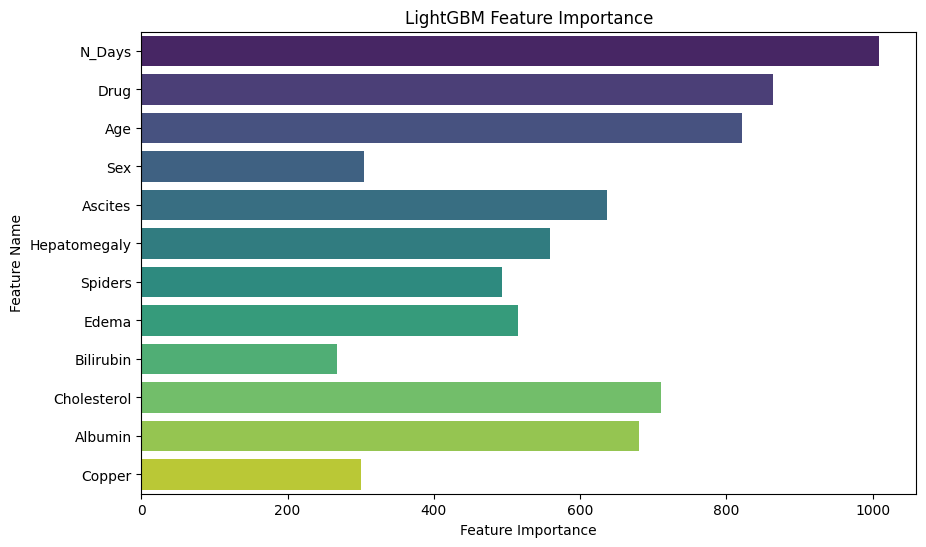

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load dataset
data = pd.read_csv('/content/cirrhosis dataset.csv')

# Identify target variable
target_column = 'Status'

# Encode categorical target variable
label_encoder = LabelEncoder()
if data[target_column].dtype == 'object':
    data[target_column] = label_encoder.fit_transform(data[target_column])

# Drop non-predictive columns safely
if 'ID' in data.columns:
    X = data.drop(columns=[target_column, 'ID'])
else:
    X = data.drop(columns=[target_column])

y = data[target_column]

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=np.number).columns

# Handle missing values for numerical columns
X[numerical_columns] = X[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# Apply OneHotEncoding to categorical features and StandardScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# ----------------------- FEATURE SELECTION -----------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
selector = SelectFromModel(rf, threshold="mean", prefit=True)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# ----------------------- HANDLING CLASS IMBALANCE -----------------------
# Plot class distribution before SMOTE
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Plot class distribution after SMOTE
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()

# ----------------------- HYPERPARAMETER TUNING -----------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_res, y_train_res)
best_rf_model = grid_search.best_estimator_

# ----------------------- ENSEMBLE MODELS -----------------------
# Define base models
rf_model = best_rf_model  # Using optimized RF model
xgb_model = XGBClassifier(eval_metric='logloss')
svm_model = SVC(probability=True, random_state=42)
xt_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
lgbm_model = LGBMClassifier()
lr_model = LogisticRegression()
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('svm', svm_model),
        ('lgbm', lgbm_model),
        ('lr', lr_model)
    ],
    voting='soft'
)

# Train and evaluate models
ensemble_models = {
    'RandomForest': rf_model,
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'ExtraTrees': xt_model,
    'LightGBM': lgbm_model,
    'Logistic Regression': lr_model,
    'MLP Classifier': mlp_model,
    'Voting Classifier': voting_clf
}

results = {}
for name, model in ensemble_models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=1),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    }

    # ROC-AUC Score
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
        metrics['ROC-AUC Score'] = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    else:
        metrics['ROC-AUC Score'] = 'Not Available'

    results[name] = metrics

# Print results
for model, metrics in results.items():
    print(f"\n{model}: {metrics}")

# ---------------------- VISUALIZATION ----------------------
# Confusion Matrix for the best model
y_pred_best = best_rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best RF Model")
plt.show()

# ---------------------- CONFUSION MATRIX FOR LIGHTGBM ----------------------
y_pred_lgbm = lgbm_model.predict(X_test)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM Model")
plt.show()
# Get feature importance from LightGBM
feature_importance = lgbm_model.feature_importances_

# Extract selected feature names correctly
selected_features = np.array(X.columns)[np.where(selector.get_support())[0]]  # Correctly map selected feature indices

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=selected_features, orient='h', palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("LightGBM Feature Importance")
plt.show()
